In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import joblib
import random

In [15]:


def generate_synthetic_students(n=100, random_state=42):
    np.random.seed(random_state)
    student_ids = [f"S{1000+i}" for i in range(n)]
    names = [f"Student_{i+1}" for i in range(n)]
    classes = np.random.choice(["Class A", "Class B", "Class C"], size=n, p=[0.35,0.35,0.3])

    # cognitive skills [0-100]
    comprehension = np.clip(np.random.normal(70, 12, n), 0, 100)
    attention     = np.clip(np.random.normal(65, 15, n), 0, 100)
    focus         = np.clip(np.random.normal(68, 14, n), 0, 100)
    retention     = np.clip(np.random.normal(60, 18, n), 0, 100)
    engagement_time = np.clip(np.random.normal(120, 40, n), 10, 400)  # minutes per week

    # True underlying score (weighted sum + noise)
    assessment_score = (
        0.30 * comprehension +
        0.25 * attention +
        0.20 * focus +
        0.15 * retention +
        0.0008 * engagement_time * 100 +  # scaled contribution
        np.random.normal(0, 6, n)
    )
    assessment_score = np.clip(assessment_score, 0, 100)

    df = pd.DataFrame({
        "student_id": student_ids,
        "name": names,
        "class": classes,
        "comprehension": np.round(comprehension,2),
        "attention": np.round(attention,2),
        "focus": np.round(focus,2),
        "retention": np.round(retention,2),
        "engagement_time": np.round(engagement_time,1),
        "assessment_score": np.round(assessment_score,2)
    })
    return df

# Test
df = generate_synthetic_students(10)
print(df.head())


  student_id       name    class  comprehension  attention  focus  retention  \
0      S1000  Student_1  Class B          64.37      51.38  59.59      36.09   
1      S1001  Student_2  Class C          76.51      43.82  63.92      63.54   
2      S1002  Student_3  Class C          64.44      86.98  59.58      73.29   
3      S1003  Student_4  Class B          64.41      61.61  93.93      63.08   
4      S1004  Student_5  Class A          72.90      66.01  67.81      57.92   

   engagement_time  assessment_score  
0            133.7             62.17  
1             49.5             66.03  
2            133.0             71.75  
3            104.6             70.23  
4             92.9             61.42  


In [16]:
# Cell 3: Quick EDA
print("Dataset shape:", df.shape)
df.describe().T


Dataset shape: (10, 9)


,count,mean,std,min,25%,50%,75%,max
comprehension,10.0,63.384,9.831828,47.04,59.2000,64.390,70.7850,76.51
attention,10.0,59.530,13.688677,43.63,48.6500,59.220,66.4975,86.98
focus,10.0,63.993,15.186639,40.56,54.7875,61.755,70.1425,93.93
retention,10.0,55.967,14.713187,33.39,48.2075,56.250,63.4250,79.03
engagement_time,10.0,117.070,35.252046,49.50,95.8250,120.300,141.8000,161.20
assessment_score,10.0,65.320,8.150014,48.22,61.6075,66.855,71.3700,74.39


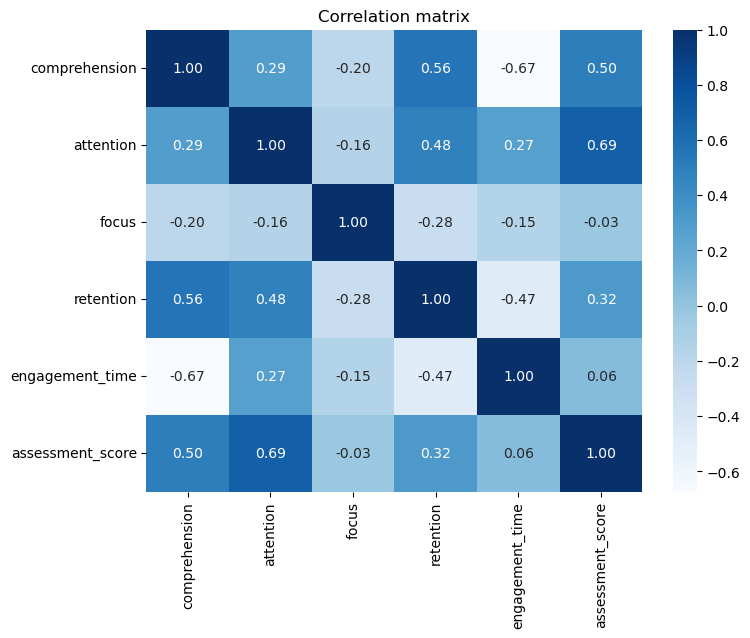

In [17]:
# Cell 4: Correlations
corr = df[["comprehension","attention","focus","retention","engagement_time","assessment_score"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation matrix")
plt.show()


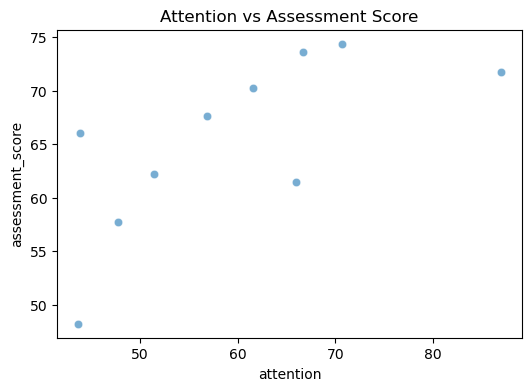

In [18]:
# Cell 5: Scatter plots (attention vs assessment)
plt.figure(figsize=(6,4))
sns.scatterplot(x="attention", y="assessment_score", data=df, alpha=0.6)
plt.title("Attention vs Assessment Score")
plt.show()


In [19]:
# Cell 6: Feature engineering & model training - predict assessment_score
features = ["comprehension","attention","focus","retention","engagement_time"]
X = df[features]
y = df["assessment_score"]

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# model
rf = RandomForestRegressor(n_estimators=150, random_state=42)
rf.fit(X_train_s, y_train)

# evaluate
y_pred = rf.predict(X_test_s)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}, R2: {r2:.3f}")

# cross-val
cv_scores = cross_val_score(rf, scaler.transform(X), y, cv=5, scoring='r2')
print("5-fold CV R2 mean:", cv_scores.mean().round(3))


RMSE: 5.006, R2: -0.448
5-fold CV R2 mean: -14.498


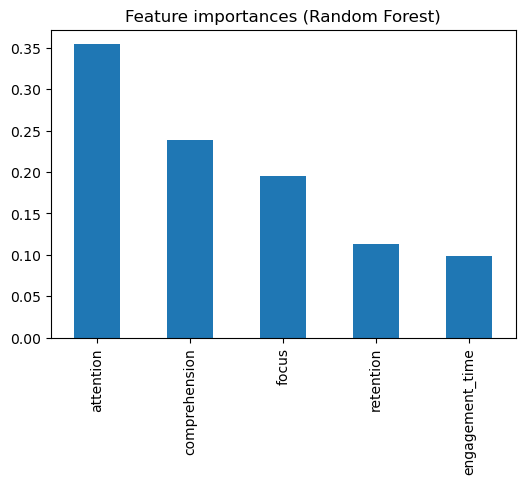

attention          0.354346
comprehension      0.238669
focus              0.195659
retention          0.112554
engagement_time    0.098772
dtype: float64


In [20]:
# Cell 7: Feature importances
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind="bar", figsize=(6,4))
plt.title("Feature importances (Random Forest)")
plt.show()
print(importances)


In [21]:
# Cell 8: Clustering - KMeans on standardized skill features to create learning personas
k = 4  # number of personas (tune as needed)
km = KMeans(n_clusters=k, random_state=42)
X_s_all = scaler.fit_transform(df[features])
clusters = km.fit_predict(X_s_all)
df["persona"] = clusters

# compute cluster centers in original space (inverse transform)
centers = scaler.inverse_transform(km.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features)
centers_df["persona"] = centers_df.index
centers_df


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,comprehension,attention,focus,retention,engagement_time,persona
0,65.053333,58.453333,77.553333,57.570,94.633333,0
1,55.990000,54.625000,60.802500,42.775,149.175000,1
2,76.510000,43.820000,63.920000,63.540,49.500000,2
3,69.105000,78.810000,50.070000,76.160,120.300000,3


In [22]:
# Cell 9: Label personas by their dominant traits (manual quick labels)
def persona_label(row):
    # naive: pick highest feature among comprehension, attention, focus, retention
    top = row[["comprehension","attention","focus","retention"]].idxmax()
    if top == "comprehension": return "Analytical Learner"
    if top == "attention": return "Attentive Learner"
    if top == "focus": return "Deep Focus Learner"
    if top == "retention": return "Memory-Oriented Learner"
    return "Balanced"

# compute average per cluster
cluster_summary = df.groupby("persona")[features + ["assessment_score"]].mean().round(2)
cluster_summary["label"] = ["Analytical Learner","Attentive Learner","Balanced Learner","Memory-Oriented Learner"][:len(cluster_summary)]
cluster_summary


,comprehension,attention,focus,retention,engagement_time,assessment_score,label
persona,,,,,,,
0,65.05,58.45,77.55,57.57,94.63,63.12,Analytical Learner
1,55.99,54.62,60.80,42.78,149.18,62.92,Attentive Learner
2,76.51,43.82,63.92,63.54,49.50,66.03,Balanced Learner
3,69.10,78.81,50.07,76.16,120.30,73.07,Memory-Oriented Learner


In [23]:
# Cell 10: Save artifacts: dataset with persona, scaler and model
df.to_csv("students_with_persona.csv", index=False)
joblib.dump(rf, "assessment_score_model_rf.joblib")
joblib.dump(scaler, "scaler.joblib")
print("Saved students_with_persona.csv, assessment_score_model_rf.joblib, scaler.joblib")


Saved students_with_persona.csv, assessment_score_model_rf.joblib, scaler.joblib


In [24]:
# top correlations with assessment_score
corr_with_target = corr["assessment_score"].drop("assessment_score").sort_values(ascending=False)
print("Top correlations with assessment_score:")
print(corr_with_target)


Top correlations with assessment_score:
attention          0.688208
comprehension      0.502490
retention          0.319475
engagement_time    0.058324
focus             -0.031113
Name: assessment_score, dtype: float64
